In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

In this notebook, we show an example on how to run eISDR and its old version iSDR that is presented in:
    
    (1) Brahim Belaoucha, Théodore Papadopoulo. Large brain effective network from EEG/MEG data and dMR information. PRNI 2017 – 7th International Workshop on Pattern Recognition in NeuroImaging, Jun 2017, Toronto, Canada.

    (2) Brahim Belaoucha, Mouloud Kachouane, Théodore Papadopoulo. Multivariate Autoregressive Model Constrained by Anatomical Connectivity to Reconstruct Focal Sources. 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), Aug 2016, Orlando, United States. 2016.

We show how you can run both using real and synthetic data

# Define sensor and source space

In [2]:
n_t = 200
n_c, n_s = 3,3
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:3, 0] = [10, 0.1, 0]
A = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0.5,0,0.5]])
for i in range(J.shape[-1]-1):
    J[:3, i+1] = np.dot(A, J[:3, i])

print(A)


[[ 0.9  -0.4   0.  ]
 [ 0.25  0.97  0.  ]
 [ 0.5   0.    0.5 ]]


# Ground truth

(0, 200)

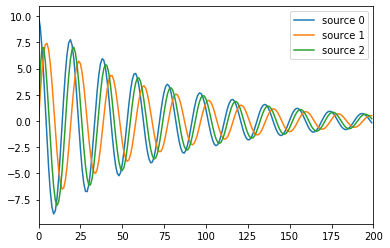

In [3]:
plt.plot(J.T)
plt.legend(['source %s'%s for s in range(n_s)])
plt.xlim(0, n_t)

# Define the structural connectivity

In [4]:
SC = np.array([[1,1,1], [1,1,0],[1,0,1]])
print( SC)

[[1 1 1]
 [1 1 0]
 [1 0 1]]


# Example 1: eiSDR order 1

## Generate EEG/MEG data

In [5]:
m_p = 1
M = np.dot(G, J[:, m_p:])

## Run eiSDR

In [6]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=[1e-2, 0.69], verbose=1, old_version=0,
                             normalize_Sstep=True, normalize_Astep=True)
cl.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s), S_tol=1e-3, normalize=0)
R = cl.Scoef_
cl.xscale

Iteration 1: nbr of active sources 3
Iteration 2: nbr of active sources 3
Stopped at iteration 2 : Change in active set tol 3.0000 > 3.0000  


array([[0.6725813 ],
       [0.81123793],
       [0.05267249]])

In [7]:
cl.a_dualgap, cl.s_dualgap

([None], [0.007429175846960304, 0.01025545932894538])

## Get eigenvalues of MVAR model

In [8]:
cl.get_phi()
cl.eigs

,real,imag,abs
eig,,,
eig_0,0.482651,0.000000,0.482651
eig_1,0.938426,0.313369,0.989365
eig_2,0.938426,-0.313369,0.989365


## Plot effective connectivity

Execution time 0.018 sec


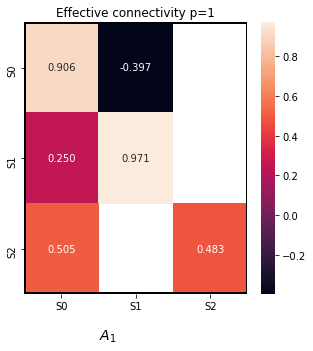

In [9]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

## Reconstruct the brain activation

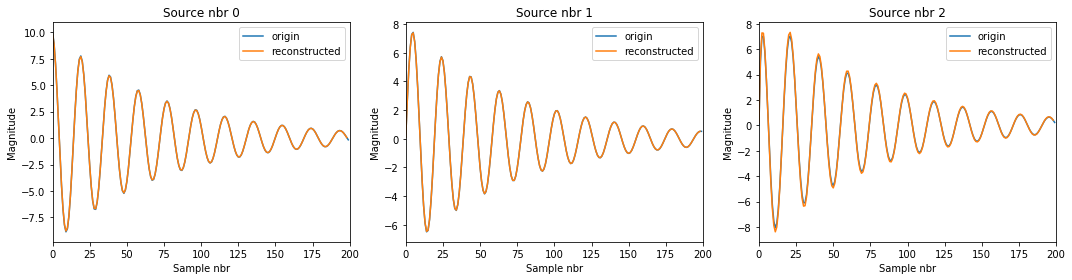

In [10]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p-1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [11]:
for i in range(m_p, n_t - m_p):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

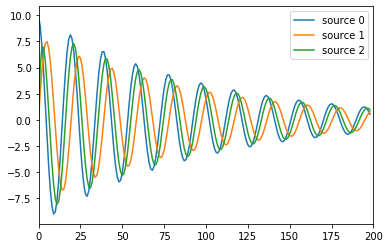

In [12]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Example 2: eiSDR order 3

## Initialize MVAR model

In [13]:
m_p = 3
Atmp = np.zeros((n_s, n_s*m_p))
Atmp[:, -n_s:] = np.eye(n_s)

## Run eiSDR

In [14]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.001, la=[1e-4, 1.], verbose=True, old_version=0, normalize_Sstep=True,
                             normalize_Astep=False)
cl.solver(G, M, SC, nbr_iter=10, model_p=m_p, A=Atmp)
R = cl.Scoef_


Iteration 1: nbr of active sources 3
Iteration 2: nbr of active sources 3
Stopped at iteration 2 : Change in active set tol 3.0000 > 3.0000  


## Compute eigenvalues of MVAR model

In [15]:
cl.get_phi()
cl.eigs

,real,imag,abs
eig,,,
eig_0,0.935053,0.314314,0.986467
eig_1,0.935053,-0.314314,0.986467
eig_2,-0.214820,0.967442,0.991006
eig_3,-0.214820,-0.967442,0.991006
eig_4,-0.722010,0.653417,0.973782
eig_5,-0.722010,-0.653417,0.973782
eig_6,0.235826,0.528915,0.579107
eig_7,0.235826,-0.528915,0.579107
eig_8,-0.515692,0.000000,0.515692


## Plot effective connectivity

Execution time 0.129 sec


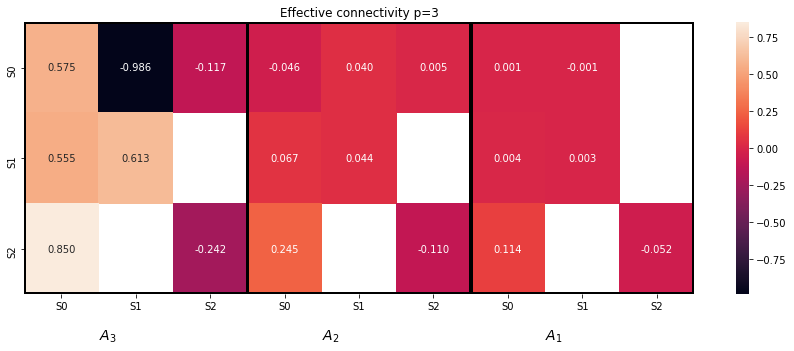

In [16]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

## Reconstruct the brain activation

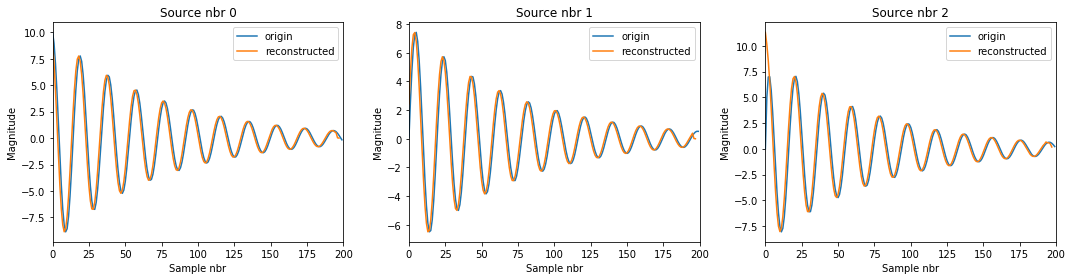

In [17]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [18]:
for i in range(m_p, R.shape[1]):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

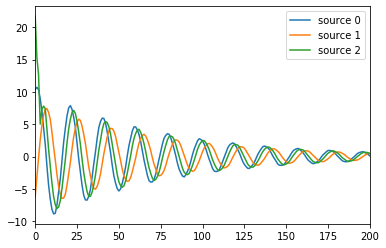

In [19]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Cross-validation eiSDR:  grid-search

## Load eiSDRcv

In [20]:
from iSDR_cython import linear_model

In [21]:
clf = linear_model.iSDRcv(l21_values=[10**-i for i in range(-1, 6, 1)],
                          la_values=[10**-i for i in range(-1, 5,1)], la_ratio_values=[1, 0.5, 0.75, 0.25],
                          normalize=[0, 1],
                          model_p=[1,2],
                         old_version=False,
                          normalize_Astep=[0],
                          normalize_Sstep=[1]
                         )

## Created random folder

In [22]:
clf.foldername

'/tmp/tmp_7ef679dd-ade7-49bb-8881-e9f8913835b4'

## Run grid cross validation

In [23]:
clf.run(G, M, SC)

Successfully created the directory /tmp/tmp_7ef679dd-ade7-49bb-8881-e9f8913835b4 


 21%|██▏       | 143/672 [00:04<00:26, 20.17it/s]/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54.505456115517816, tolerance: 2.195485501645109
  positive)
 23%|██▎       | 157/672 [00:05<00:21, 24.06it/s]/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 62.124421894148924, tolerance: 2.195485501645109
  positive)
 28%|██▊       | 191/672 [00:07<00:23, 20.85it/s]/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8258762535925896, tolerance: 2.2615179334530886
  positive)
 52%|█████▏    | 350/672 [00:14<00:10, 30.88it/s]/home/bbelaouc/Woksp

Successfully deleted the directory /tmp/tmp_7ef679dd-ade7-49bb-8881-e9f8913835b4


## Results

In [24]:
print('Execution time %.3f sec'%clf.time)
df = clf.results

Execution time 33.385 sec


In [25]:
df.Obj.min()

0.004600752726309098

## Parameters resulting to smallest Obj

In [26]:
x  = df[df.Obj == df.Obj.min()]

In [27]:
x

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,normalize_Astep,normalize_Sstep,Obj
271,0.000029,3,116.188999,3.550937,2.500114,0.00001,0.0001,0.25,1,0,0.000038,0,1,0.004601


## Reconstruct with optimal parameters

In [28]:
cl = ciSDR.linear_model.iSDR(l21_ratio=x.ls_reg.values[0], la=[x.la_reg_a.values[0], x.la_reg_r.values[0]],
                             old_version=False, normalize_Astep=x.normalize_Astep.values[0],
                            normalize_Sstep=x.normalize_Sstep.values[0])
cl.solver(G, M, SC, nbr_iter=10, model_p=x.p.values[0], A=np.eye(n_s))
R = cl.Scoef_

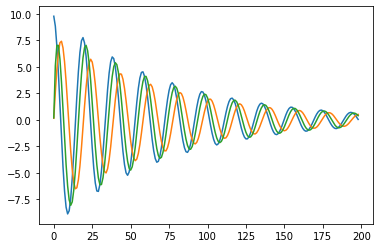

In [29]:
cl.bias_correction()
plt.plot(cl.Jbias_corr.T)

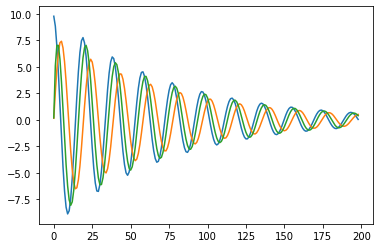

In [30]:
plt.plot(cl.Scoef_.T)

## Reconstructed effective connectivity

Execution time 0.021 sec


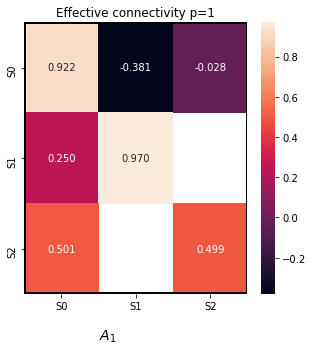

In [31]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

## Reconstructed dynamics

In [32]:
cl.get_phi()
cl.eigs

,real,imag,abs
eig,,,
eig_0,0.521861,0.000000,0.521861
eig_1,0.934929,0.314297,0.986344
eig_2,0.934929,-0.314297,0.986344


# Real data

We are using EEG data acquired during famous face recognition task. we should see an activation around 170 ms in the fusiform area

In [33]:
from scipy.io import loadmat

In [34]:
data = loadmat('S1_p1_EEGT800.mat')

In [35]:
fs = 1/np.diff(data['time'])[0][0]

## L1 prior on MVAR

In [36]:
cl = ciSDR.linear_model.iSDR(l21_ratio=5, la=[1e-11, 1], verbose=1, old_version=False,
                             normalize_Sstep=False, normalize_Astep=False)
cl.solver(data['G'], data['M']*1e12, data['SC'].astype(int), model_p=2, A=None, normalize=False)
cl.bias_correction()
cl.coef_ = cl.Jbias_corr
R = cl.coef_*1e-12

Iteration 1: nbr of active sources 95
Iteration 2: nbr of active sources 57
Iteration 3: nbr of active sources 52
Iteration 4: nbr of active sources 52
Stopped at iteration 4 : Change in active set tol 52.0000 > 52.0000  


### Brain reconstruction

Text(0.5, 1.0, 'Reconstructed brain activation')

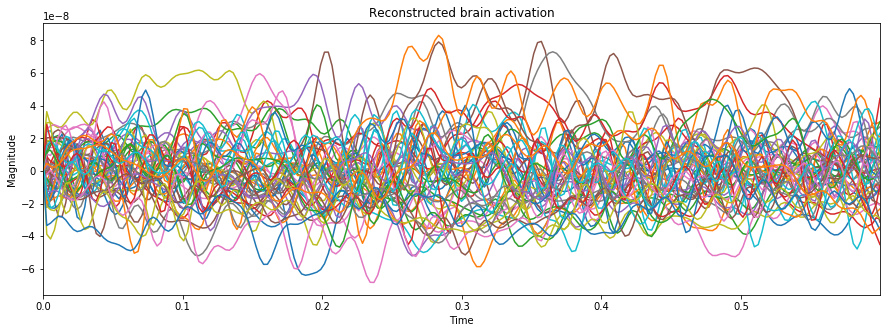

In [37]:
R = cl.coef_*1e-12
time = [i/fs for i in range(R.shape[1])]
plt.figure(figsize=(15,5))
plt.plot(time, R.T);
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Reconstructed brain activation')

### Effective connectivity (Sparse)

Execution time 109.890 sec


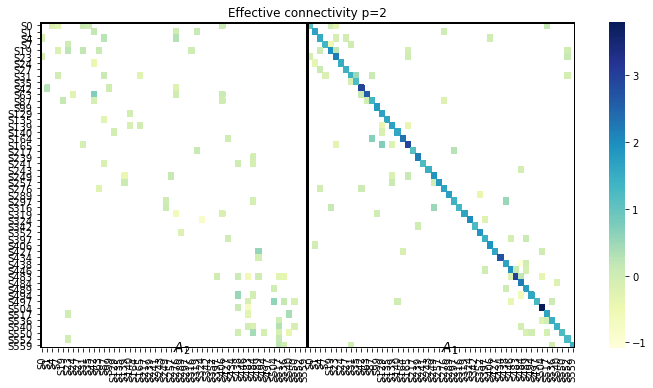

In [38]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective(fig_size=6, annot=False, cmap="YlGnBu")

### Left fusiform area

In [39]:
ix = np.where(cl.active_set[-1] == 42)[0][0]

Text(0, 0.5, 'Magnitude')

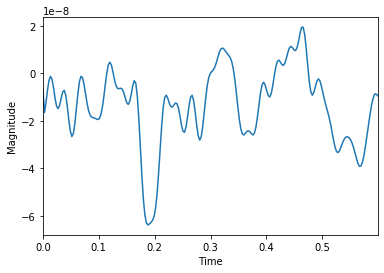

In [40]:
plt.plot(time, 1e-12*cl.Jbias_corr[ix, :])
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')

## L2 prior on MVAR

In [77]:
cl = ciSDR.linear_model.iSDR(l21_ratio=5, la=[1e-12, 0], verbose=1, old_version=False, normalize_Sstep=False,
                             normalize_Astep=True, max_iter=[10000, 5000])
cl.solver(data['G'], data['M']*1e12, data['SC'].astype(int), model_p=2, A=None, normalize=False)
cl.bias_correction()
cl.coef_ = cl.Jbias_corr
R = cl.coef_*1e-12


Iteration 1: nbr of active sources 95


/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7385965108182804e-05, tolerance: 4.987677554819521e-08
  positive)


Iteration 2: nbr of active sources 79


/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8534662560272782e-05, tolerance: 4.987677554819521e-08
  positive)


Iteration 3: nbr of active sources 74


/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1958924853908378e-05, tolerance: 4.987677554819521e-08
  positive)


Iteration 4: nbr of active sources 73


/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.165264178191606e-05, tolerance: 4.987677554819521e-08
  positive)


Iteration 5: nbr of active sources 72


/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1402527854143136e-05, tolerance: 4.987677554819521e-08
  positive)


Iteration 6: nbr of active sources 71


/home/bbelaouc/Wokspace/scikit-learn/sklearn/linear_model/_coordinate_descent.py:482: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.315286578826403e-05, tolerance: 4.987677554819521e-08
  positive)


Iteration 7: nbr of active sources 71
Stopped at iteration 7 : Change in active set tol 71.0000 > 71.0000  


### Brain activation reconstruction

Text(0.5, 1.0, 'Reconstructed brain activation')

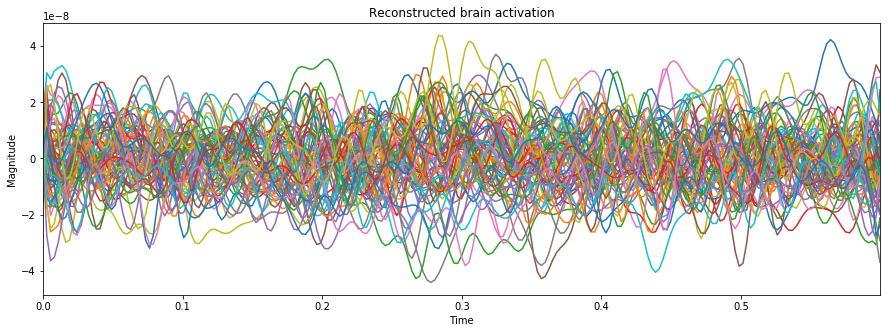

In [78]:
time = [i/fs for i in range(R.shape[1])]
plt.figure(figsize=(15,5))
plt.plot(time, R.T);
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Reconstructed brain activation')

### Effective connectivity (less sparse) 

Execution time 3351.181 sec


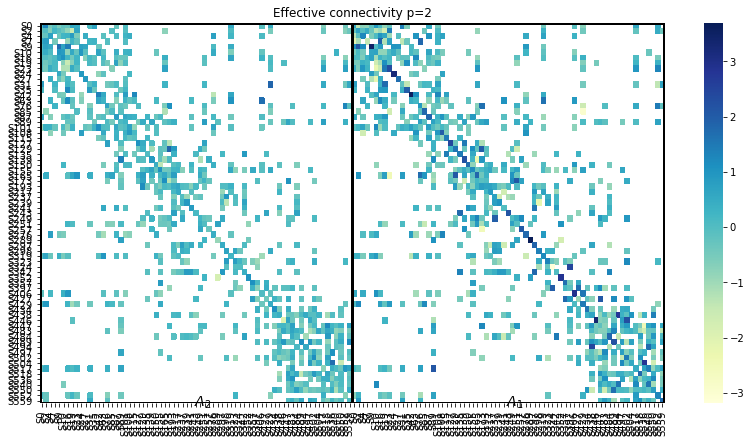

In [79]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective(fig_size=7, annot=False, cmap="YlGnBu")

### Left fusiform area

In [80]:
ix = np.where(cl.active_set[-1] == 42)[0][0]

Text(0, 0.5, 'Magnitude')

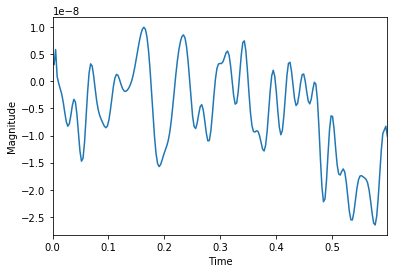

In [81]:
plt.plot(time, 1e-12*cl.coef_[ix, :])
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')

# Example on how to run iSDR

You can use the iSDR EEG/MEG source reconstruction by setting the 'old_version' to True

In [82]:
cl = ciSDR.linear_model.iSDR(l21_ratio=x.ls_reg.values[0], la=[x.la_reg_a.values[0], x.la_reg_r.values[0]],
                             old_version=True, normalize_Sstep=False)
cl.solver(G, M, SC, model_p=x.p.values[0], A=np.eye(n_s))
R = cl.Scoef_

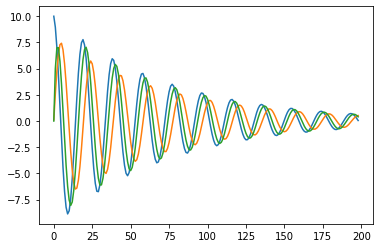

In [83]:
plt.plot(R.T);

In [84]:
cl.get_phi()

Execution time 0.182 sec


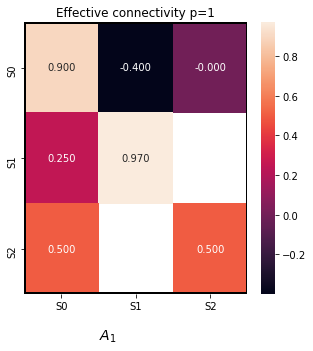

In [85]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

In [86]:
cl.la

[0.0, 0.0]

In [87]:
cl.eigs

,real,imag,abs
eig,,,
eig_0,0.499996,0.000000,0.499996
eig_1,0.935000,0.314285,0.986408
eig_2,0.935000,-0.314285,0.986408
